In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

from utils import *

In [2]:
print(f"GPU available ? {torch.cuda.is_available()}")

#  use gpu if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

GPU available ? True


In [3]:
from torch.utils.data import Dataset, DataLoader, random_split
from torch.utils.data import WeightedRandomSampler
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y
        
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, idx):
        x = self.X[idx, :]
        tensor = torch.from_numpy(x).float()
        class_id = self.y[idx]
        class_id = torch.tensor([class_id]).float()
        return tensor, class_id
        
    def getY(self):
        return self.y
    
class Data_Loaders():
    def __init__(self, batch_size, test_size=0.2, scaling=True, weighting=True):
        self.weighting=weighting
        self.scaling=scaling
        
        X = np.loadtxt("data/protein_train.data")
        y = np.loadtxt("data/protein_train.solution")
        
        #X_test__ = np.loadtxt("data/protein_test.data")
        #X_valid__ = np.loadtxt("data/protein_valid.data")
        print("Data Loaded")

        X = remove_hard_corrs(X)
        
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=113)

        if scaling:
            self.scaler=StandardScaler()
            X_train = self.scaler.fit_transform(X_train)
            X_test = self.scaler.transform(X_test)
            #X_test__ = self.scaler.transform(X_test__)
            #X_valid__ = self.scaler.transform(X_valid__)
            print("Data standardized")
        
        self.train_set = CustomDataset(X_train, y_train)
        self.test_set = CustomDataset(X_test, y_test)
        
        
        # Weighting
        if weighting:
            target_list = y_train
            _, counts = np.unique(target_list, return_counts=True)
            class_weights = [1 - (x / sum(counts)) for x in counts]
            class_weights = torch.tensor(class_weights).float().to(device)
            class_weights_all = class_weights[target_list]

            weighted_sampler = WeightedRandomSampler(
                weights=class_weights_all,
                num_samples=len(class_weights_all),
                replacement=True
            )
            
            self.train_loader = DataLoader(self.train_set, batch_size=batch_size, sampler=weighted_sampler)
            print("Using weighted train set")
        
        else:
            self.train_loader = DataLoader(self.train_set, batch_size=batch_size)
            
        self.test_loader = DataLoader(self.test_set, batch_size=1)


In [4]:
dataset = Data_Loaders(64, scaling=True, weighting=True)

Data Loaded
Removed 11 useless columns
Data standardized
Using weighted train set


In [10]:
from sklearn.metrics import balanced_accuracy_score


class BinaryMLP(nn.Module):
    def __init__(self, **kwargs):
        super().__init__()
        self.hidden_layer_1 = nn.Linear(
            in_features=kwargs["input_shape"], out_features=256
        )
        self.batchnorm1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(p=0.1)
        
        self.hidden_layer_2 = nn.Linear(
            in_features=256, out_features=128
        )
        self.dropout2 = nn.Dropout(p=0.1)
        
        self.batchnorm2 = nn.BatchNorm1d(128)
        
        self.out_layer = nn.Linear(
            in_features=128, out_features=1
        )
        

    def forward(self, features):
        x = self.hidden_layer_1(features)
        x = self.batchnorm1(x)
        x = self.dropout1(x)
        x = torch.relu(x)
        x = self.hidden_layer_2(x)
        x = self.batchnorm2(x)
        x = self.dropout2(x)
        x = torch.relu(x)
        out = torch.sigmoid(self.out_layer(x))
        return out
    

def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(y_pred)
    y_pred_tag = y_pred_tag.detach().cpu().numpy().flatten()
    y_test = y_test.cpu().numpy().flatten()
    
    acc = balanced_accuracy_score(y_pred_tag, y_test)
    
    acc = np.round(acc * 100, 2)
    
    return acc

"""y_pred_tag = torch.round(y_pred)

correct_results_sum = (y_pred_tag == y_test).sum().float()
acc = correct_results_sum/y_test.shape[0]
acc = torch.round(acc * 100)

return acc"""


base_size = 941

# create a model from `AE` autoencoder class
# load it to the specified device, either gpu or cpu
model = BinaryMLP(input_shape=base_size).to(device)

# create an optimizer object
# Adam optimizer with learning rate 1e-3
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

# mean-squared error loss
criterion = nn.BCELoss()

In [11]:
accuracy_stats = {
    'train': [],
    "test": []
}
loss_stats = {
    'train': [],
    "test": []
}

epochs=15

In [12]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

for epoch in range(epochs):
    loss = 0
    epoch_acc = 0
    for batch_features, batch_labels in dataset.train_loader:
        # reshape mini-batch data to [N, 941] matrix
        # load it to the active device
        batch_features = batch_features.view(-1, base_size).to(device)
        batch_labels = batch_labels.view(-1, 1).to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = model(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_labels)
        acc = binary_acc(outputs, batch_labels)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
        epoch_acc += acc.item()
    
    # compute the epoch training loss
    epoch_loss = loss / len(dataset.train_loader)
    epoch_acc = epoch_acc / len(dataset.train_loader)
    accuracy_stats["train"].append(epoch_acc)
    loss_stats["train"].append(epoch_loss)
    
    # VALIDATION    
    with torch.no_grad():
        
        test_epoch_loss = 0
        test_epoch_acc = 0
        
        model.eval()
        for X_test_batch, y_test_batch in dataset.test_loader:
            X_test_batch, y_test_batch = X_test_batch.to(device), y_test_batch.to(device)
            
            y_test_pred = model(X_test_batch)
                        
            test_loss = criterion(y_test_pred, y_test_batch)
            test_acc = binary_acc(y_test_pred, y_test_batch)
            
            test_epoch_loss += test_loss.item()
            test_epoch_acc += test_acc.item()
        accuracy_stats["test"].append(test_epoch_acc / len(dataset.test_loader))
        loss_stats["test"].append(test_epoch_loss / len(dataset.test_loader))
    
    # display the epoch training loss
    print(f'Epoch {epoch+0:03}: | Train Loss: {epoch_loss:.5f} | Train Acc: {epoch_acc:.3f} \
        | Test Loss: {(test_epoch_loss / len(dataset.test_loader)):.5f}| Test Acc: {(test_epoch_acc / len(dataset.test_loader)):.3f}')
    

warnings.filterwarnings("default", category=UserWarning)

Epoch 000: | Train Loss: 0.32039 | Train Acc: 86.382         | Test Loss: 0.26536| Test Acc: 88.564
Epoch 001: | Train Loss: 0.15486 | Train Acc: 94.166         | Test Loss: 0.22746| Test Acc: 91.416
Epoch 002: | Train Loss: 0.09448 | Train Acc: 96.679         | Test Loss: 0.22346| Test Acc: 93.072
Epoch 003: | Train Loss: 0.06646 | Train Acc: 97.770         | Test Loss: 0.22897| Test Acc: 93.524
Epoch 004: | Train Loss: 0.04929 | Train Acc: 98.406         | Test Loss: 0.25499| Test Acc: 93.025
Epoch 005: | Train Loss: 0.03944 | Train Acc: 98.784         | Test Loss: 0.26661| Test Acc: 93.628
Epoch 006: | Train Loss: 0.03399 | Train Acc: 98.842         | Test Loss: 0.26768| Test Acc: 93.844
Epoch 007: | Train Loss: 0.02451 | Train Acc: 99.171         | Test Loss: 0.35380| Test Acc: 92.583
Epoch 008: | Train Loss: 0.02466 | Train Acc: 99.189         | Test Loss: 0.35334| Test Acc: 94.023
Epoch 009: | Train Loss: 0.02494 | Train Acc: 99.125         | Test Loss: 0.33116| Test Acc: 93.985


Text(0.5, 1.0, 'Train-Test Loss/Epoch')

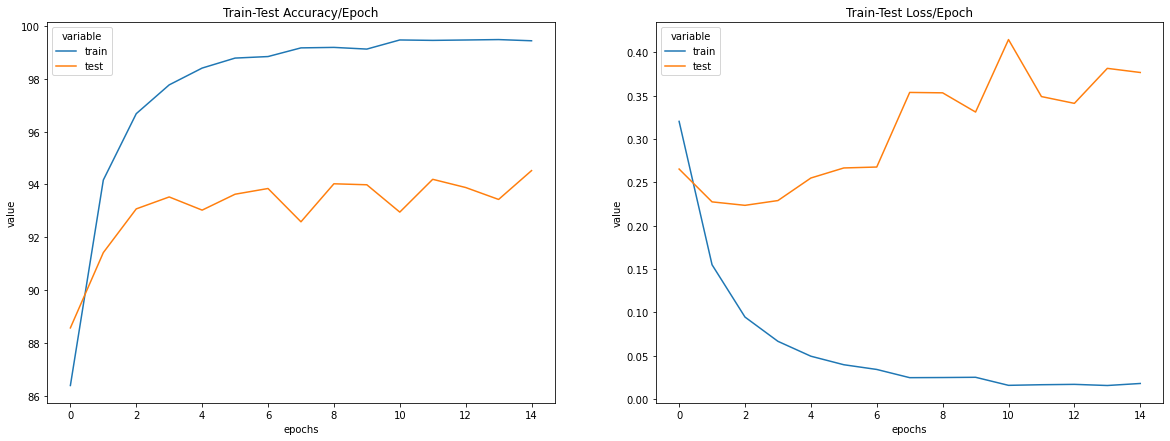

In [13]:
import seaborn as sns
# Create dataframes
train_test_acc_df = pd.DataFrame.from_dict(accuracy_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
train_test_loss_df = pd.DataFrame.from_dict(loss_stats).reset_index().melt(id_vars=['index']).rename(columns={"index":"epochs"})
# Plot the dataframes
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20,7))
sns.lineplot(data=train_test_acc_df, x = "epochs", y="value", hue="variable",  ax=axes[0]).set_title('Train-Test Accuracy/Epoch')
sns.lineplot(data=train_test_loss_df, x = "epochs", y="value", hue="variable", ax=axes[1]).set_title('Train-Test Loss/Epoch')

In [14]:
from sklearn.metrics import confusion_matrix

y_pred_list = []
y_test = []
model.eval()
with torch.no_grad():
    for X_batch, y_batch in dataset.test_loader:
        X_batch = X_batch.to(device)
        y_test.append(y_batch.cpu().numpy())
        y_test_pred = model(X_batch)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())
    y_test = np.asarray(y_test).flatten().tolist()
y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

confusion_matrix(y_test, y_pred_list)
print(f"Balanced score is {balanced_accuracy_score(y_test, y_pred_list)}")

Balanced score is 0.9202424797201728
